# ¿Cuál es la mejor tarifa?

Proyecto para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. __El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad__.

Se realizará un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. __Se contará con los datos de 500 clientes de Megaline__: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. __Se analizará el comportamiento de los clientes y determinará qué tarifa de prepago genera más ingresos__.

## Diccionario de datos

En este proyecto, se trabajará con cinco tablas diferentes.

La tabla `users` (datos sobre los usuarios):
 
- user_id: identificador único del usuario.
- first_name: nombre del usuario.
- last_name: apellido del usuario.
- age: edad del usuario (en años).
- reg_date: fecha de suscripción (dd, mm, aa).
- churn_date: la fecha en la que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando fue extraída esta base de datos).
- city: ciudad de residencia del usuario.
- plan: nombre de la tarifa.

La tabla `calls` (datos sobre las llamadas):
 
- id: identificador único de la llamada.
- call_date: fecha de la llamada.
- duration: duración de la llamada (en minutos).
- user_id: el identificador del usuario que realiza la llamada.

La tabla `messages` (datos sobre los SMS):
 
- id: identificador único del SMS.
- message_date: fecha del SMS.
- user_id: el identificador del usuario que manda el SMS.

La tabla `internet` (datos sobre las sesiones web):
 
- id: identificador único de la sesión.
- mb_used: el volumen de datos gastados durante la sesión (en megabytes).
- session_date: fecha de la sesión web.
- user_id: identificador del usuario.

La tabla `plans` (datos sobre las tarifas):
 
- plan_name: nombre de la tarifa.
- usd_monthly_fee: pago mensual en dólares estadounidenses.
- minutes_included: minutos incluidos al mes.
- messages_included: SMS incluidos al mes.
- mb_per_month_included: datos incluidos al mes (en megabytes).
- usd_per_minute: precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos, - el operador cobrará el minuto 101).
- usd_per_message: precio por SMS tras exceder los límites del paquete.
- usd_per_gb: precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes).

## Inicialización

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st 
import seaborn as sns
import math as mt # Cargar todas las librerías

In [2]:
plt.style.use('ggplot') #Dar estética a los gráficos

## Cargar datos

In [3]:
calls = pd.read_csv('/datasets/megaline_calls.csv') # Carga los archivos de datos en diferentes DataFrames
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

## Tarifas

In [4]:
plans.info() # Imprime la información general/resumida sobre el DataFrame de las tarifas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [5]:
plans # Imprime una muestra de los datos para las tarifas

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Se observan todas las características de los planes a estudiar, la información se entiende claramente y el tipo de datos es correcto, no necesita cambios por ahora.

## Corregir datos

No hay nada que corregir en este dataset por el momento.

## Enriquecer los datos

Para el análisis posterior, se deberá hacer una conversión de megabytes a gigabytes.

## Usuarios/as

In [6]:
users.info() # Imprime la información general/resumida sobre el DataFrame de usuarios

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
users.head() # Imprime una muestra de datos para usuarios

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Se observa que las columnas de fecha (`churn_date` y `reg_date`) están en formato erróneo, por lo cual serán corregidas, los valores de la columna `city` están en mayúsculas y minúsculas por lo que se comprobará la existencia de duplicados implícitos y de ser encontrados serán trabajados.

Se observan valores ausentes en la columna `churn_date` los cuales indican que el usuario en cuestión no se ha dado de baja del plan al momento en que se recopiló esta información.

### Corregir los datos

In [8]:
print(users.duplicated().sum())
print()
print(len(users['city'].value_counts()))
print()
print(len(users['city'].str.lower().value_counts()))
print()
users['reg_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
print(users['reg_date'].dtype)

0

73

73

datetime64[ns]


Se corrigen los tipos de datos que informan fechas y se comprueba, a través de un conteo de valores únicos, que no hay duplicados implícitos en la columna `city`. 

### Enriquecer los datos

No se necesita enriquecer los datos por el momento.

## Llamadas

In [9]:
calls.info() # Imprime la información general/resumida sobre el DataFrame de las llamadas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
calls.head() # Imprime una muestra de datos para las llamadas

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Se observa (al igual que en el DataFrame anterior) que la columna que informa la fecha de la llamada está en un formato erróneo.

### Corregir los datos

In [11]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
print(calls['call_date'].dtype)

datetime64[ns]


Se corrige el tipo de datos de la columna `call_date`.

In [12]:
print(len(calls[calls['duration'] == 0]))
print(len(calls))

26834
137735


In [13]:
calls = calls[calls['duration'] != 0]

__Se descubre una gran cantidad de llamadas con duración 0, debe tratarse de llamadas cortadas y/o perdidas, no se tomarán en cuenta ya que no generan cobros__.

### Enriquecer los datos

In [14]:
def rminutes(row):
    
    duration = row['duration']
    return mt.ceil(duration)
        
calls['duration'] = calls.apply(rminutes, axis=1)
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


Se redondea la duración de las llamadas hacia arriba para seguir los lineamientos de la compañía.

## Mensajes

In [15]:
messages.info() # Imprime la información general/resumida sobre el DataFrame de los mensajes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
messages.head() # Imprime una muestra de datos para los mensajes

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Se observa (al igual que en el DataFrame anterior) que la columna que informa la fecha de la llamada está en un formato erróneo.

### Corregir los datos

In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
print(messages['message_date'].dtype)

datetime64[ns]


Se corrige el tipo de datos de la columna `message_date`.

### Enriquecer los datos

El dataset no necesita ser enriquecido por el momento.

## Internet

In [18]:
internet.info() # Imprime la información general/resumida sobre el DataFrame de internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
internet.head() # Imprime una muestra de datos para el tráfico de internet

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Se observa (al igual que en el DataFrame anterior) que la columna que informa la fecha de la llamada está en un formato erróneo.

### Corregir los datos

In [20]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
print(internet['session_date'].dtype)

datetime64[ns]


Se corrige el tipo de datos de la columna `session_date`.

### Enriquecer los datos

__Cuando se agrupen los datos para el análisis se tendrá que redondear hacia arriba lo valores de la transformación de mbegabyte a gigabyte__, debido a que es un redondeo mensual no se puede hacer en el preanálisis.

## Estudiar las condiciones de las tarifas

In [21]:
plans # Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Se repasan las condiciones de cada tarifa para proceder con el análisis.

## Agregar datos por usuario


In [22]:
user_calls = calls.merge(users,on='user_id') # Cálculo el número de llamadas hechas por cada usuario al mes.
user_calls['month'] = user_calls['call_date'].dt.month
user_calls_m = user_calls.groupby(['user_id','month'])['id'].count()

user_calls_m.head()

user_id  month
1000     12       16
1001     8        22
         9        38
         10       47
         11       49
Name: id, dtype: int64

Mediante un `.merge()` sumamos al dataset de las llamadas, la información de los usuarios, se crea la columna `month` a partir de la columna `call_date` y finalmente se agrupa `user_calls` por id de usuario y mes, realizando un conteo de las llamadas por usuario al mes. 

El mismo procedimiento se repetirá para minutos, megabytes y mensajes, solo que aplicando `.sum()` en el caso de los minutos y los megabytes.

In [23]:
user_minutes_m = user_calls.groupby(['user_id','month'])['duration'].sum() # Cálculo la cantidad de minutos usados por cada usuario al mes. 

In [24]:
user_messages_m = messages.merge(users, on='user_id') # Cálculo el número de mensajes enviados por cada usuario al mes.
user_messages_m['month'] = user_messages_m['message_date'].dt.month
user_messages_m = user_messages_m.groupby(['user_id','month'])['id'].count()

In [25]:
user_internet_m = internet.merge(users,on='user_id') # Cálcula el volumen del tráfico de Internet usado por cada usuario al mes.
user_internet_m['month'] = user_internet_m['session_date'].dt.month
user_internet_m = user_internet_m.groupby(['user_id','month'])['mb_used'].sum()

Ya están todas las variables agrupadas por usuario y por mes, solo queda juntarlas en un único dataset.

In [26]:
df_concat = pd.concat([user_calls_m, user_minutes_m, user_internet_m,user_messages_m], axis='columns') # Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
df_concat = df_concat.set_axis(['calls_num','minutes_incall','mb_used','message_num'],axis=1)
df_concat = df_concat.reset_index('month')

df_concat.head()

,month,calls_num,minutes_incall,mb_used,message_num
user_id,,,,,
1000,12,16.0,124.0,1901.47,11.0
1001,8,22.0,182.0,6919.15,30.0
1001,9,38.0,315.0,13314.82,44.0
1001,10,47.0,393.0,22330.49,53.0
1001,11,49.0,426.0,18504.30,36.0


Mediante `concat` agrupamos el __número de llamadas, minutos hablados, megabytes usados, y mensajes enviados, por usuario y por mes__. 

Ahora si podemos hacer la transformación de megabytes a gigabytes.

In [27]:
print(df_concat['mb_used'].isna().sum()) #Búsqueda de duplicados
df_concat['mb_used'] = df_concat['mb_used'].fillna(0) #Corrección de duplicados
print(df_concat['mb_used'].isna().sum())
df_concat['gb'] = df_concat['mb_used'] / 1024 #Creación de la columna 'gb'

def rinternet(row): #Mediante esta función se redondea hacia arriba el número de gigabytes mensuales
    
    gb = row['gb']
    return mt.ceil(gb)
        
df_concat['gb_used'] = df_concat.apply(rinternet, axis=1)
df_concat = df_concat.drop(columns=['mb_used','gb']) #Se eliminan las columnas sobrantes
df_concat = df_concat.reset_index()

df_concat.head()

16
0


,user_id,month,calls_num,minutes_incall,message_num,gb_used
0,1000,12,16.0,124.0,11.0,2
1,1001,8,22.0,182.0,30.0,7
2,1001,9,38.0,315.0,44.0,14
3,1001,10,47.0,393.0,53.0,22
4,1001,11,49.0,426.0,36.0,19


El `concat` genera valores ausentes, ya que hay clientes que en algunos meses no usaron internet, pero si, otros servicios, por lo que antes de poder redondear es necesario procesar estos valores ausentes, reemplazandolos con 0.

Posteriormente, mediante una función, __se redondea hacia arriba el número de gigabytes usados__, quedando una columna de valores enteros y calzando con las políticas de cobro de la compañía.

Ahora queda agregar los datos específicos de cada plan para poder hacer los cálculos de ingreso por cliente.

In [28]:
user_plan = df_concat.merge(users,on='user_id') # Añade la información de la tarifa
user_plan = user_plan.drop(['first_name', 'last_name', 'age', 'city', 'reg_date', 'churn_date'],axis=1) #Eliminar info residual
user_plan = user_plan.set_axis(['user_id', 'month', 'calls_num', 'minutes_incall', 'message_num', 'gb_used', 'plan_name'],axis=1)

user_plan = user_plan.merge(plans, on='plan_name') #Se agrega la info detallada de cada plan

user_plan['message_num'].fillna(0, inplace=True) # Se reemplazan con 0 los valores ausentes generados en el concat anterior
user_plan['calls_num'].fillna(0, inplace=True)
user_plan['minutes_incall'].fillna(0, inplace=True)

user_plan.head()

,user_id,month,calls_num,minutes_incall,message_num,gb_used,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,16.0,124.0,11.0,2,ultimate,1000,30720,3000,70,7,0.01,0.01
1,1006,11,2.0,10.0,15.0,3,ultimate,1000,30720,3000,70,7,0.01,0.01
2,1006,12,7.0,59.0,139.0,32,ultimate,1000,30720,3000,70,7,0.01,0.01
3,1008,10,54.0,476.0,21.0,17,ultimate,1000,30720,3000,70,7,0.01,0.01
4,1008,11,50.0,446.0,37.0,24,ultimate,1000,30720,3000,70,7,0.01,0.01


Se realiza un `merge` de `df_concat` con el dataset de usuarios, para saber qué plan usa cada uno, luego (mediante otro `merge`) se agrega la información completa del plan al dataset, quedando este __listo para calcular los pagos mensuales de los clientes__.

In [29]:
def minutes(row): #Función para calcular el cobro de minutos
    
    plan_name = row['plan_name']
    minutes_incall = row['minutes_incall']
    
    if plan_name == 'surf':
        if minutes_incall > 500:
            return (minutes_incall-500)*0.03
        else:
            return 0
    if plan_name == 'ultimate':
        if minutes_incall > 3000:
            return (minutes_incall-3000)*0.01
        else:
            return 0
        
user_plan['extra_usd_min'] = user_plan.apply(minutes, axis=1)

def gb(row): #Función para calcular el cobro de uso de gigabytes mensual
    
    plan_name = row['plan_name']
    gb_used = row['gb_used']
    
    if plan_name == 'surf':
        if gb_used > 15:
            return (gb_used-15)*10
        else:
            return 0
    if plan_name == 'ultimate':
        if gb_used > 30:
            return (gb_used-30)*7
        else:
            return 0
        
user_plan['extra_usd_gb'] = user_plan.apply(gb, axis=1)

def messages(row): #Función para calcular el cobro por envío de mensajes
    
    plan_name = row['plan_name']
    message_num = row['message_num']
    
    if plan_name == 'surf':
        if message_num > 50:
            return (message_num-50)*0.03
        else:
            return 0
    if plan_name == 'ultimate':
        if message_num > 1000:
            return (message_num-1000)*0.01
        else:
            return 0
        
user_plan['extra_usd_message'] = user_plan.apply(messages, axis=1)
user_plan['total_income'] = user_plan['usd_monthly_pay'] + user_plan['extra_usd_min'] + user_plan['extra_usd_gb'] + user_plan['extra_usd_message']
user_plan.head()

,user_id,month,calls_num,minutes_incall,message_num,gb_used,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,extra_usd_min,extra_usd_gb,extra_usd_message,total_income
0,1000,12,16.0,124.0,11.0,2,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0,0.0,70.0
1,1006,11,2.0,10.0,15.0,3,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0,0.0,70.0
2,1006,12,7.0,59.0,139.0,32,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,14,0.0,84.0
3,1008,10,54.0,476.0,21.0,17,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0,0.0,70.0
4,1008,11,50.0,446.0,37.0,24,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0,0.0,70.0


Mediante funciones se calcula automáticamente el cobro para uso de llamadas, mensajes e internet, con las condiciones específicas proporcionadas por la compañía (se encuentran al inicio del documento). Mediantes estos calculos __obtenemos un dataset con los montos específicos generados mensualmente por cada cliente, y además, con columnas específicas para cobros extra__.

## Estudio del comportamiento de usuario

### Llamadas

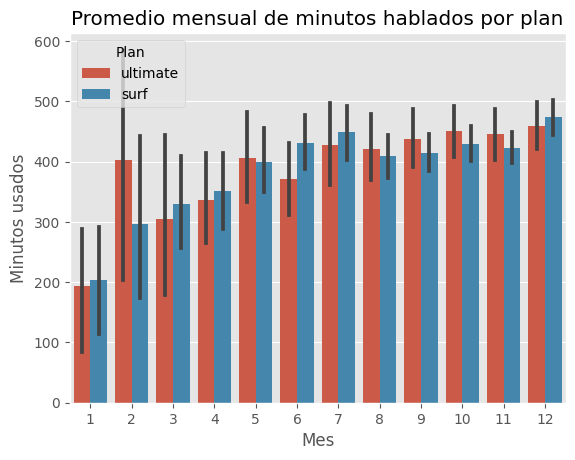

In [30]:
sns.barplot(x='month', y='minutes_incall', data=user_plan, hue='plan_name').set_title('Promedio mensual de minutos hablados por plan')
plt.ylabel('Minutos usados')
plt.xlabel('Mes')
plt.legend(title='Plan')

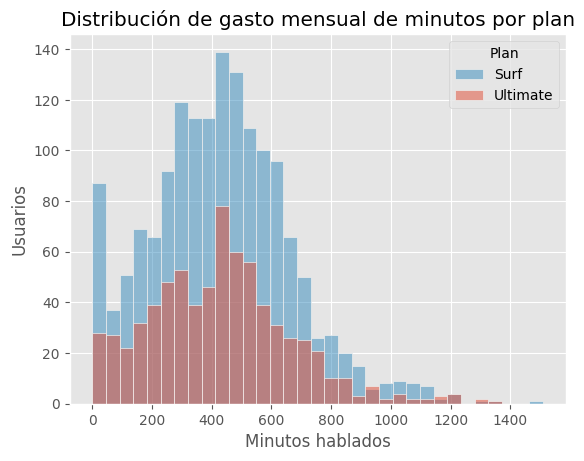

In [31]:
sns.histplot(x='minutes_incall', hue='plan_name', data=user_plan).set_title('Distribución de gasto mensual de minutos por plan')
plt.ylabel('Usuarios')
plt.xlabel('Minutos hablados')
plt.legend(title='Plan', labels=['Surf', 'Ultimate'])

In [32]:
print(user_plan[user_plan['plan_name'] == 'surf']['minutes_incall'].describe()) # Calcula la media y la varianza de la duración mensual de llamadas.
print()
print(user_plan[user_plan['plan_name'] == 'ultimate']['minutes_incall'].describe())

count    1573.000000
mean      428.749523
std       234.453150
min         0.000000
25%       272.000000
50%       425.000000
75%       576.000000
max      1510.000000
Name: minutes_incall, dtype: float64

count     720.000000
mean      430.450000
std       240.508762
min         0.000000
25%       260.000000
50%       424.000000
75%       565.250000
max      1369.000000
Name: minutes_incall, dtype: float64


Text(0.5, 0, 'Plan')

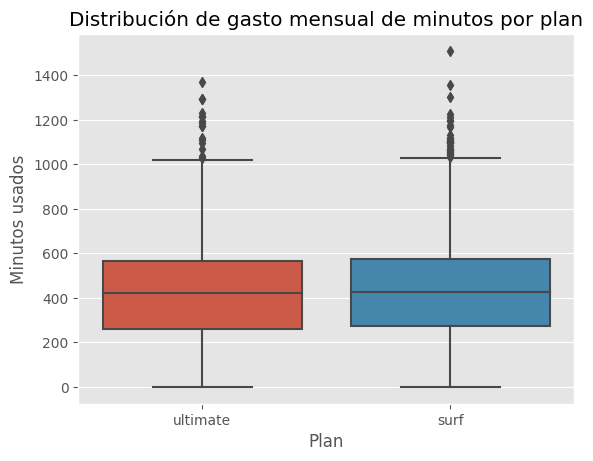

In [33]:
sns.boxplot(y='minutes_incall', x='plan_name', data=user_plan).set_title('Distribución de gasto mensual de minutos por plan')
plt.ylabel('Minutos usados')
plt.xlabel('Plan')

#### Conclusiones

En cuanto a la duración mensual de las llamadas, se puede apreciar que __existen muy pocas diferencias en cuanto al plan surf y al plan ultimate__, ya que, los minutos promedio por mes y la varianza de estos son prácticamente iguales en ambos planes (a pesar de sus notorias diferencias en cuanto a capacidades y precio). 

Queda al descubierto que (al menos en esta muestra) __los usuarios del plan ultimate, están muy lejos de usar los 3.000 minutos mensuales de su plan (430 en promedio__, con un máximo de 1292), mientras que __los usuarios del plan surf en promedio usan 428 minutos de 500 disponibles__, y que en aproximadamente 1/4 de los registros, las llamadas mensuales de este plan sobrepasaron el límite de 500 minutos mensuales.

Sólo se observa una diferencia notoria en el mes de febrero, donde los usuarios del plan ultimate hablaron, en promedio al mes, más de 100 minutos, que los usuarios del plan surf.

### Mensajes

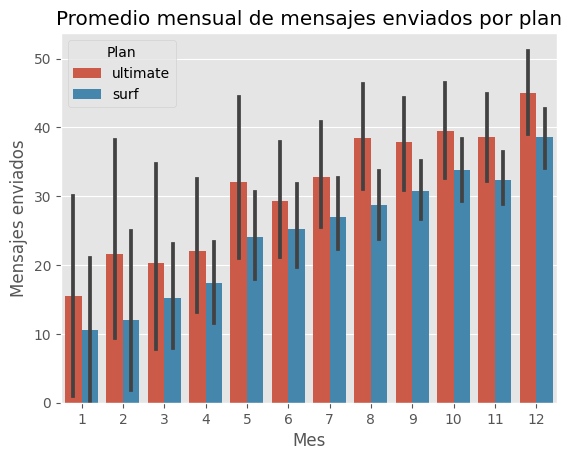

In [34]:
sns.barplot(x='month', y='message_num', data=user_plan, hue='plan_name').set_title('Promedio mensual de mensajes enviados por plan')
plt.ylabel('Mensajes enviados')
plt.xlabel('Mes')
plt.legend(title='Plan')

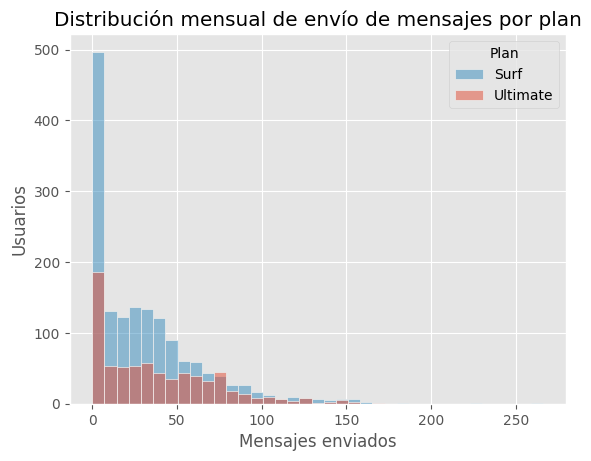

In [35]:
sns.histplot(x='message_num', hue='plan_name', data=user_plan).set_title('Distribución mensual de envío de mensajes por plan')
plt.ylabel('Usuarios')
plt.xlabel('Mensajes enviados')
plt.legend(title='Plan', labels=['Surf', 'Ultimate'])

In [36]:
print(user_plan[user_plan['plan_name'] == 'surf']['message_num'].describe()) 
print()
print(user_plan[user_plan['plan_name'] == 'ultimate']['message_num'].describe())

count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: message_num, dtype: float64

count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: message_num, dtype: float64


Text(0.5, 0, 'Plan')

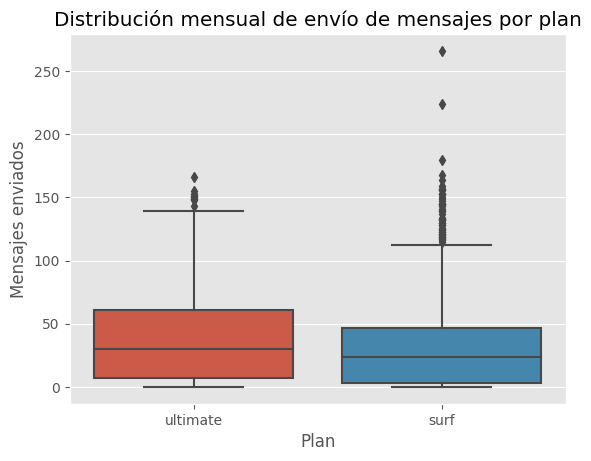

In [37]:
sns.boxplot(y='message_num', x='plan_name', data=user_plan).set_title('Distribución mensual de envío de mensajes por plan')
plt.ylabel('Mensajes enviados')
plt.xlabel('Plan')

#### Conclusiones

En cuanto a los mensajes, se puede apreciar que en general, __los usuarios del plan ultimate envían más mensajes al mes que los del plan surf__ (en promedio, 6 mensajes más), esta diferencia se observa pronunciadamente en los meses de marzo, mayo y agosto. En cuanto a la distribución, podemos apreciar en el histograma que, en el plan surf, la cantidad de mensajes mensuales enviados cae drásticamente después del límite mensual de 50, mientras que en el plan ultimate, la pendiente es más suave.

Al igual que con los minutos, en el plan surf, aproximadamente 1/4 de los registros mensuales de mensajes sobrepasa el límite de 50, mientras que el plan ultimate, el límite de 1.000 está lejos de ser alcanzado.

### Internet

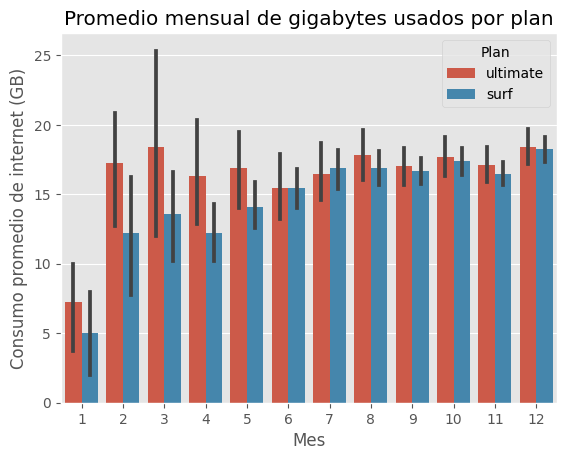

In [38]:
sns.barplot(x='month', y='gb_used', data=user_plan, hue='plan_name').set_title('Promedio mensual de gigabytes usados por plan')
plt.ylabel('Consumo promedio de internet (GB)')
plt.xlabel('Mes')
plt.legend(title='Plan')

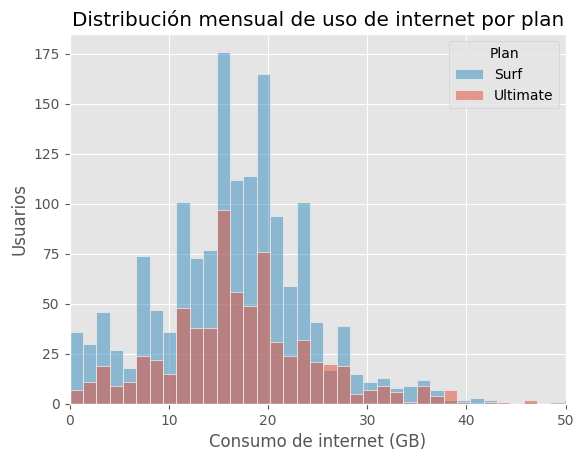

In [39]:
sns.histplot(x='gb_used', hue='plan_name', data=user_plan).set_title('Distribución mensual de uso de internet por plan')
plt.ylabel('Usuarios')
plt.xlabel('Consumo de internet (GB)')
plt.xlim(0, 50)
plt.legend(title='Plan', labels=['Surf', 'Ultimate'])

In [40]:
print(user_plan[user_plan['plan_name'] == 'surf']['gb_used'].describe()) 
print()
print(user_plan[user_plan['plan_name'] == 'ultimate']['gb_used'].describe())

count    1573.000000
mean       16.670693
std         7.847522
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_used, dtype: float64

count    720.000000
mean      17.306944
std        7.670108
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: gb_used, dtype: float64


Text(0.5, 0, 'Plan')

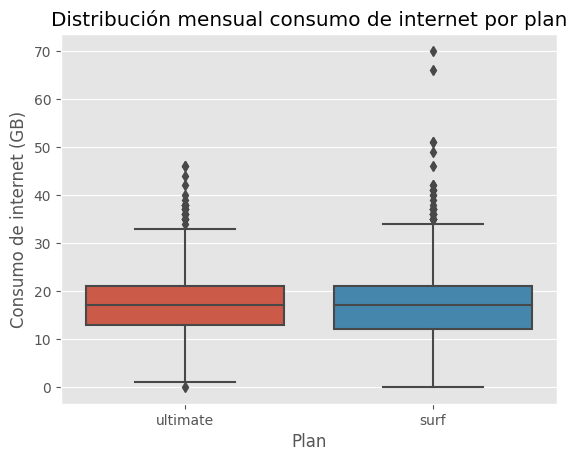

In [41]:
sns.boxplot(y='gb_used', x='plan_name', data=user_plan).set_title('Distribución mensual consumo de internet por plan')
plt.ylabel('Consumo de internet (GB)')
plt.xlabel('Plan')

#### Conclusiones

En promedio, __los consumos de internet mensuales de ambos planes son parecidos__ (17 GB aproximadamente), sin embargo, al analizar el detalle mensual, podemos obsevar que __en los meses de febrero, marzo y abril, los datos usados en promedio en el plan ultimate superan por más de 2GB a los usados en el plan surf__.

Observando los gráficos de caja podemos apreciar que más de la mitad de los registros mensuales analizados, en el plan surf, sobrepasan el límite mensual de 15 GB, mientras que en el plan ultimate es un porcentaje muy bajo el que sobreṕasa el límite de 30 GB.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

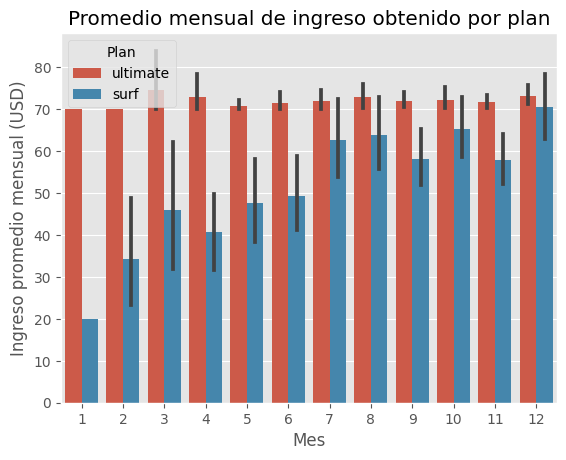

In [42]:
sns.barplot(x='month', y='total_income', data=user_plan, hue='plan_name').set_title('Promedio mensual de ingreso obtenido por plan')
plt.ylabel('Ingreso promedio mensual (USD)')
plt.xlabel('Mes')
plt.legend(title='Plan')

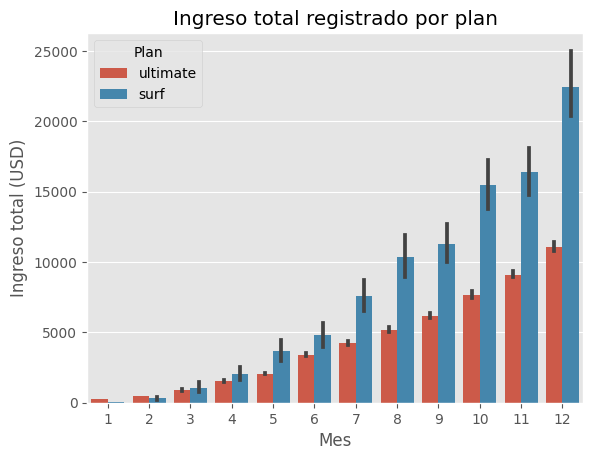

In [43]:
sns.barplot(x='month', y='total_income', data=user_plan, hue='plan_name', estimator=sum).set_title('Ingreso total registrado por plan')
plt.ylabel('Ingreso total (USD)')
plt.xlabel('Mes')
plt.legend(title='Plan')

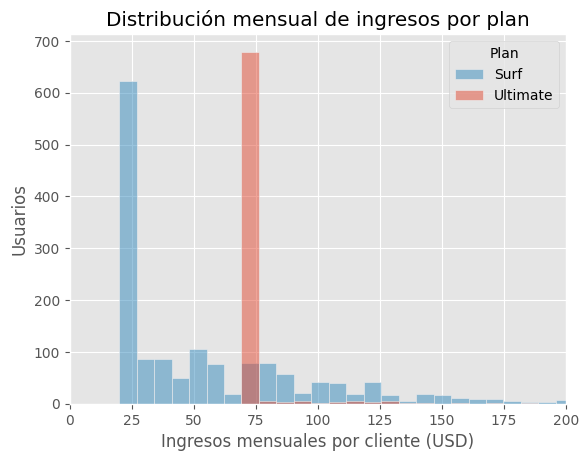

In [44]:
sns.histplot(x='total_income', hue='plan_name', data=user_plan).set_title('Distribución mensual de ingresos por plan')
plt.ylabel('Usuarios')
plt.xlabel('Ingresos mensuales por cliente (USD)')
plt.xlim(0, 200)
plt.legend(title='Plan', labels=['Surf', 'Ultimate'])

In [45]:
print(user_plan[user_plan['plan_name'] == 'surf']['total_income'].describe()) 
print()
print(user_plan[user_plan['plan_name'] == 'ultimate']['total_income'].describe())

count    1573.000000
mean       60.706408
std        55.388042
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.370000
Name: total_income, dtype: float64

count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: total_income, dtype: float64


Text(0.5, 0, 'Plan')

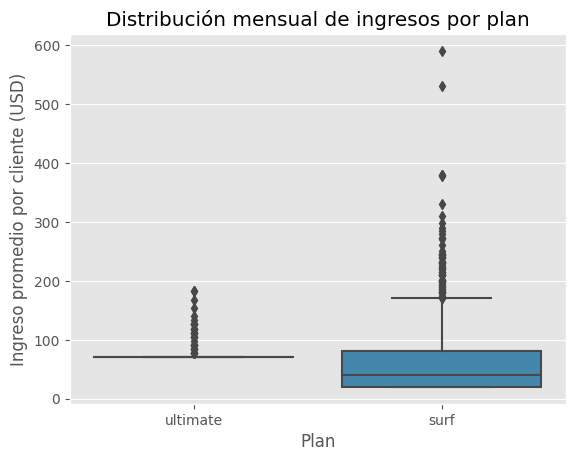

In [46]:
sns.boxplot(y='total_income', x='plan_name', data=user_plan).set_title('Distribución mensual de ingresos por plan')
plt.ylabel('Ingreso promedio por cliente (USD)')
plt.xlabel('Plan')

#### Conclusiones

En base a la muestra analizada, se puede observar que en promedio, __un usuario del plan últimate genera 12 dolares más en ingresos a la compañía que uno del plan surf__. Podemos observar también que los usuarios del plan ultimate rara vez generan ingresos extra a la mensualidad fija del plan, en comparación con __los usuarios del plan surf, que sobrepasan frecuentemente los límites de su plan (mas del 50% de los registros)__, generando ingresos extra considerables. Segun los datos observados, esto se debe a que los usuarios de la compañía usan los servicios de forma muy parecida independiente del plan que hayan contratado.

Cabe destacar que si bien el ingreso promedio de un usario del plan ultimate es mayor al de uno del plan surf, si la proporción de clientes del plan surf es considerablemente mayor a la del ultimate, el primero podría generar mas ingresos totales que el segundo (como se da en esta muestra, en el segundo gráfico de barras).

## Prueba las hipótesis estadísticas

Se probará la siguiente hipótesis: __Son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf__.

La hipótesis nula es que los ingresos promedio no varían según el plan contratado, si se rechaza, quiere decir que hay una variación estadísticamente considerable entre los ingresos promedio del plan ultimate y el plan surf.
Se usará una prueba estadística para comparar las medias de dos muestras de datos con varianzas diferentes.

In [47]:
print(user_plan[user_plan['plan_name'] == 'surf']['total_income'].mean())
print()
print(user_plan[user_plan['plan_name'] == 'ultimate']['total_income'].mean())
print()

alpha = 0.05
results = st.ttest_ind(user_plan[user_plan['plan_name'] == 'surf']['total_income'],
                       user_plan[user_plan['plan_name'] == 'ultimate']['total_income'],equal_var=False) # Prueba las hipótesis
print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

60.706408137317226

72.31388888888888

valor p: 3.1703905481135734e-15
Rechazamos la hipótesis nula


Se comprueba estadísticamente que __el ingreso promedio de el plan ultimate es mayor que el del plan surf__.

Se probará la siguiente hipótesis: __El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones__.

La hipótesis nula es que los ingresos promedio no varían según las ubicaciones seleccionadas, si se rechaza, quiere decir que hay una variación estadísticamente considerable entre los ingresos promedio en las localizaciones analizadas.
Se usará una prueba estadística para comparar las medias de dos muestras de datos con varianzas iguales.

In [48]:
hipo = user_plan.merge(users, on='user_id') # Prueba las hipótesis
hipony = hipo[hipo['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income']
print(hipony.mean())
print()
hipo_rest = hipo[hipo['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income']
print(hipo_rest.mean())
print()
alpha = 0.05
results = st.ttest_ind(hipony,hipo_rest,equal_var=True) # Prueba las hipótesis
print('valor p:', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

59.92135278514589

65.2227713987474

valor p: 0.04355743162134274
Rechazamos la hipótesis nula


Se comprueba estdísticamente que __hay diferencia entre el ingreso promedio del área `NY-NJ` con el del resto de las áreas, siendo el primero menor que el segundo__.

## Conclusión general

- __1 Importar datos:__ La importación de datos concluye sin ningún problema.

- __2 Pre-procesar datos:__ Se corrigen algunas columnas con tipo de dato erróneo, columnas relacionadas a fechas que serán importantes a la hora de analizar los datos mensualmente.

__3 Conclusiones de análisis de datos:__

Por medio de los dataframes se logra crear un archivo con los datos mensuales de consumo de los clientes, incluyendo también el ingreso de dólares a la compañía y cuanto de ese ingreso es por la tarifa mensual fija o por cargos extra.

__Los comportamiento de usuario son parecidos, independiente del plan contratado y de si se generan o no cobros adicionales por uso sobre el límite__ (solo los mensajes son un poco influenciados por el límite mensual), siendo los usuarios del plan surf quienes muy frecuentemente exceden el límite de consumo mensual (más del 50% de los registros de ingreso mensual superan los 20 dolares mensuales) en comparación con los del plan ultimate que rara vez lo hacen (solo valores atípicos).

En promedio al mes, __un usuario del plan ultimate genera más 14 dolares más en ingresos que un usuario del plan surf__.

En la muestra, __el plan surf es más popular__ y genera más ingresos totales que el ultimate, sin embargo al ser un registro tan pequeño hace falta mucha más información para concluir sobre la preferencia de los clientes por uno u otro plan.

__4 Pruebas estadísticas:__

- Se comprueba estadísticamente que __el ingreso promedio de el plan ultimate es mayor que el del plan surf__.
- Se comprueba estdísticamente que __hay diferencia entre el ingreso promedio del área `NY-NJ` con el del resto de las áreas, siendo el primero menor que el segundo__.